# Project 2: Advanced Lane Line Detection

## Notebook 2: Pipeline Refinement
In this notebook, the pipeline class object is refined for better functionality, and attempts are then made to expand its abilities to handle the project videos. This second notebook was necessary because the first became too long to easily edit. It seems the pipeline class contains a large enough amount of code to make the editing process within a Jupyter notebook cell unwieldy, so the modification of the class object will be done in a text editor, and tested in this notebook with an autoreloaded import. Please reference lane_finder.py for the code of the class object.

#### Notes:
- Need to add averaging of lane polynomial curves over recent frames to smooth performance.
- Need to add integrity check which will cause pipeline to refit lanes if estimates go awry, as they did in the challenge video test from the last notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Import the lane finding pipeline
from lane_finder import Lane_Finder

# Import tools for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload
%autoreload 1
%aimport lane_finder

In [3]:
# I will refine the parameters here, and ultimately change them in the lane_finder.py file
# when I am satisfied with the values
# The white lines are usually 30ft long, 10 ft apart, meaning each line/space combo is 40ft,
# and it looks like our lane window goes down around 4 white lines, so ~160ft = ~49m
lanefinder = Lane_Finder(mtx=None, 
                         dist=None, 
                         calib_dir='camera_cal/',
                         nx=9,
                         ny=6,
                         objp=None,
                         src=None,
                         dst=None,
                         l_thresh=None,
                         s_thresh=(120, 255), 
                         sx_thresh=(20, 100),
                         frame_buffer=5,
                         margin=100,
                         padding=200,
                         lane_length=49.0,
                         lane_width=3.7,
                         nwindows=9,
                         minpix=50,
                         output_dir='output_images/'
                        )

Calibrating camera with images in camera_cal/
Corners not found for  calibration1.jpg
Corners not found for  calibration4.jpg
Corners not found for  calibration5.jpg
Calibration successful!


Lane Finder output for straight_lines1.jpg:


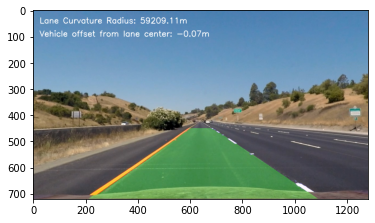

Lane Finder output for straight_lines2.jpg:


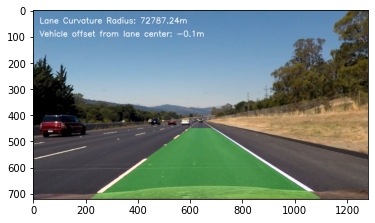

Lane Finder output for test1.jpg:


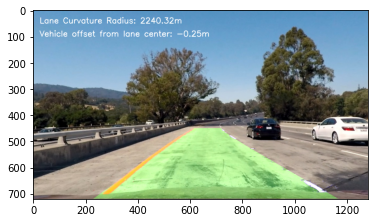

Lane Finder output for test2.jpg:


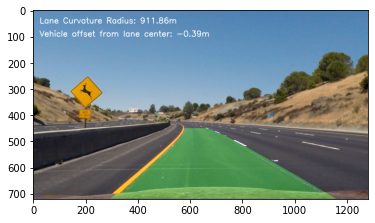

Lane Finder output for test3.jpg:


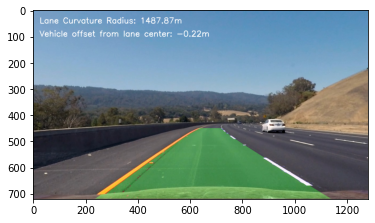

Lane Finder output for test4.jpg:


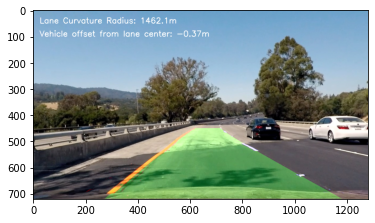

Lane Finder output for test5.jpg:


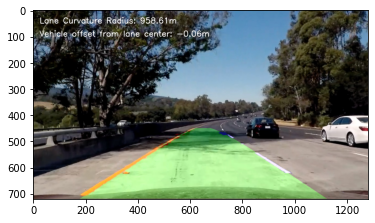

Lane Finder output for test6.jpg:


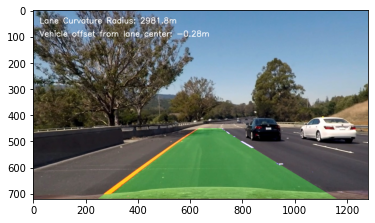

In [4]:
# First, we'll apply the pipeline to the images in the test_images folder, and save the results
# into the output_images folder
test_images = os.listdir('test_images/')
for test_image in test_images:
    image = plt.imread('test_images/' + test_image)
    output = lanefinder.process_image(image)
    print('Lane Finder output for {}:'.format(test_image))
    plt.imshow(output)
    plt.show()
    # Write to file, converting from RGB to BGR
    cv2.imwrite('output_images/' + test_image, output[:, :, ::-1])

Lane Finder output for straight_lines1.jpg:


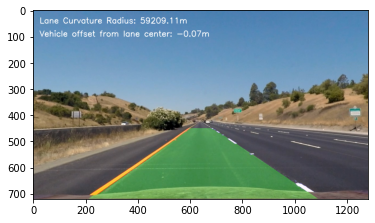

Lane Finder output for straight_lines2.jpg:


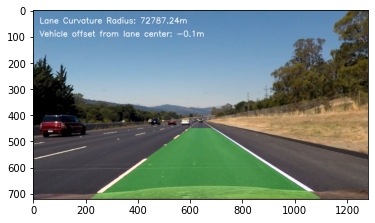

Lane Finder output for test1.jpg:


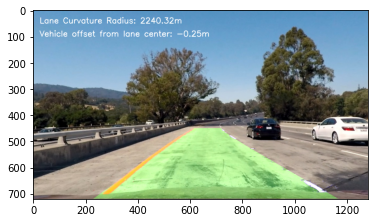

Lane Finder output for test2.jpg:


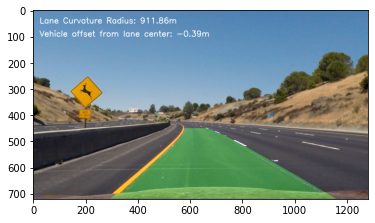

Lane Finder output for test3.jpg:


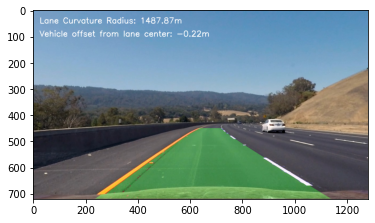

Lane Finder output for test4.jpg:


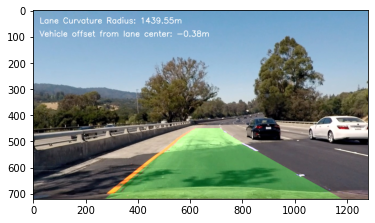

Lane Finder output for test5.jpg:


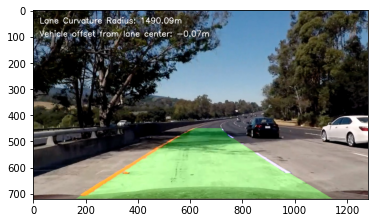

Lane Finder output for test6.jpg:


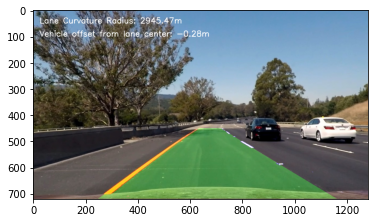

In [5]:
# The pipeline is having difficulty on test5.jpg, because of a shadow. Let's see if adding
# a lightness threshold will help
lanefinder.l_thresh = (50, 255)
for test_image in test_images:
    image = plt.imread('test_images/' + test_image)
    output = lanefinder.process_image(image)
    print('Lane Finder output for {}:'.format(test_image))
    plt.imshow(output)
    plt.show()
    # Write to file, converting from RGB to BGR
    cv2.imwrite('output_images/' + test_image, output[:, :, ::-1])

In [6]:
# These results are satisfactory, now to run the pipeline on the project video, save, and view
%time lanefinder.process_video('project_video.mp4', write_path='project_video_output.mp4')

Moviepy - Building video output_images/project_video_output.mp4.
Moviepy - Writing video output_images/project_video_output.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_output.mp4
Wall time: 2min 44s


In [7]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/project_video_output.mp4'))

In [8]:
# These results are satisfactory.
# As a sanity check, we know from the last notebook that the base of the lane is about 1000
# pixels wide, and that the lane should be about 3.7m wide. Let's see if our meter to pixel
# conversion in the x direction is working out decently
lanefinder.xm_per_pixel * 1000

3.9255865926717917

In [9]:
# This is relatively close to 3.7m

#### Challenge Video
The pipeline worked well enough on the project video. Now let's see how it looks on the challenge video.

In [10]:
%time lanefinder.process_video('challenge_video.mp4', write_path='challenge_video_output_1.mp4')

Moviepy - Building video output_images/challenge_video_output_1.mp4.
Moviepy - Writing video output_images/challenge_video_output_1.mp4



Moviepy - Done !
Moviepy - video ready output_images/challenge_video_output_1.mp4
Wall time: 58.1 s


In [11]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/challenge_video_output_1.mp4'))

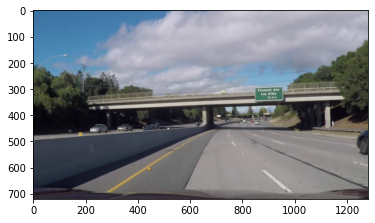

In [12]:
# We can see that the change in pavement surface running down the center of the lane is 
# throwing off the line detection. Some careful threshold adjustments may help to solve this.
# To get an idea, we need to isolate a useful from this video to work with
vidcap = cv2.VideoCapture('challenge_video.mp4')
count = 0
while count < 75:
    #print(count)
    #cv2.imshow('frame', image)
    #cv2.waitKey(0)
    success, image = vidcap.read()
    count+=1
    
# Reverse RGB channels
image = image[:, :, ::-1]
plt.imshow(image);

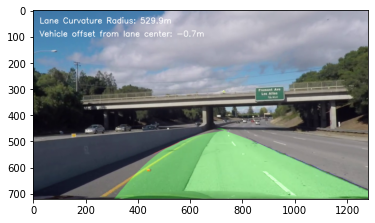

In [13]:
# Run the pipeline on this image
output = lanefinder.process_image(image)
plt.imshow(output);

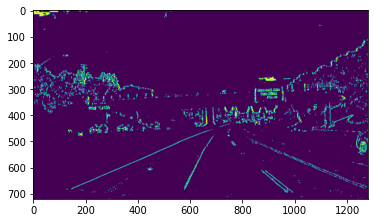

In [15]:
# Let's see the binary image being produced to diagnose the issue
output = lanefinder.binary_lane_img(image, diagnostic=False)
plt.imshow(output);

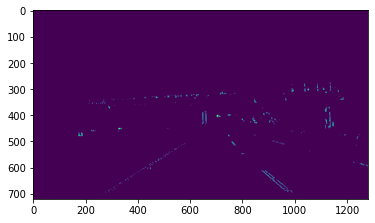

In [16]:
# We can see that the lane lines are being detected less than the changes in pavement
# The green color indicates that it is being detected by the x gradient. The blue is 
# associated with saturation, and it is not playing a role here
# I will first try adding lightness thresholding
output = lanefinder.binary_lane_img(image, 
                                    h_thresh=(0, 30),
                                    l_thresh=(130, 255),
                                    s_thresh=(12, 255),
                                    sx_thresh=(15, 255), 
                                    diagnostic=False)
plt.imshow(output);

In [17]:
# These thresholds seem to be filtering out the dark lines in the pavement, by adding the 
# condition that the pixels must be above a certain lightness threshold. I also changed
# the saturation thresholds. Let's see how these parameters affect the challenge video
lanefinder.h_thresh=(0, 30)
lanefinder.l_thresh=(130, 255)
lanefinder.s_thresh=(12, 255)
lanefinder.sx_thresh=(15, 255)
lanefinder.margin=75
lanefinder.always_windows = True

%time lanefinder.process_video('challenge_video.mp4', write_path='challenge_video_output_2.mp4')

Moviepy - Building video output_images/challenge_video_output_2.mp4.
Moviepy - Writing video output_images/challenge_video_output_2.mp4



Moviepy - Done !
Moviepy - video ready output_images/challenge_video_output_2.mp4
Wall time: 59.3 s


In [18]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/challenge_video_output_2.mp4'))

In [ ]:
# We can see that this still has not worked. I think it's getting to the point where I've taken
# all the time on this project that I can for now, I will come back to it another time to take
# on these challenge videos.